# StarCraft Pro Scout Modeling - Non-Parametric Models - SVC
We'll now try SVC to see how it compares to KNN. 

In [1]:
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

import scikitplot as skplt

from imblearn.over_sampling import RandomOverSampler

# Update sys.path
import sys
sys.path.append("../modules")

from scproModules import print_confusion_matrix, plot_grid_scores, score_df

import pickle

In [2]:
# Pickle opening code to import cleaned data
with open('./pickles/sc_dataclean.pickle','rb') as read_file:
    scns = pickle.load(read_file)

# Support Vector Classifiers
Train and test with Support Vector Classifiers.

## Non-Parametric Model Features
As a reminder, here are all of the non-parametric features  
- APM
- UniqueHotkeys
- MinimapAttacks
- MinimapRightClicks
- NumberOfPACs
- ActionsInPAC
- WorkersMade
- UniqueUnitsMade
- ComplexAbilityUsed


## Binary classifying
- Split into binary Contender and Non-Contender classes.

In [3]:
# Rename labels and resplit. The target label must be 0
scns.LeagueIndex.replace({8:1, 7:1, 6:1, 5:0, 4:0, 3:0, 2:0, 1:0}, inplace=True)
scns.LeagueIndex.value_counts().sort_index()

0    2667
1     700
Name: LeagueIndex, dtype: int64

## Train-Test-Split

- Split into main training and test sets. 
- The choice of a 25/75 split is rather arbitrary. With such a small set of pro data it's hard to know whether it's better to err on the side of a larger or smaller test set. 

In [4]:
np_features = ['APM',
 'UniqueHotkeys',
 'MinimapAttacks',
 'MinimapRightClicks',
 'NumberOfPACs',
 'ActionsInPAC',
 'WorkersMade',
 'UniqueUnitsMade',
 'ComplexAbilityUsed']

In [5]:
X = scns.loc[:, np_features]
y = scns['LeagueIndex']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [7]:
print(len(X_train))
print(len(X_test))

2525
842


## Oversampling Imbalanced Classes
- Before we do our training and validate splits we'll want to oversample to account for the severely imbalanced classes. 

In [8]:
ros  = RandomOverSampler(random_state=0)
X_ros, y_ros = ros.fit_resample(X_train, y_train)

In [9]:
X_ros.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3996 entries, 0 to 3995
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   APM                 3996 non-null   float64
 1   UniqueHotkeys       3996 non-null   float64
 2   MinimapAttacks      3996 non-null   float64
 3   MinimapRightClicks  3996 non-null   float64
 4   NumberOfPACs        3996 non-null   float64
 5   ActionsInPAC        3996 non-null   float64
 6   WorkersMade         3996 non-null   float64
 7   UniqueUnitsMade     3996 non-null   float64
 8   ComplexAbilityUsed  3996 non-null   float64
dtypes: float64(9)
memory usage: 281.1 KB


## Simple Training Splits

In [10]:
X_train.shape

(2525, 9)

### Baseline 
- We'll run the simple baseline again with the DummyClassifier for reference.

In [11]:
clf = DummyClassifier(strategy='uniform')
clf.fit(X_train, y_train)
y_base_pred = clf.predict(y_test)
score_df(y_test, y_base_pred)

,Scores
f1,0.254545
precision,0.178241
recall,0.445087
accuracy,0.464371
average_precision,0.193347


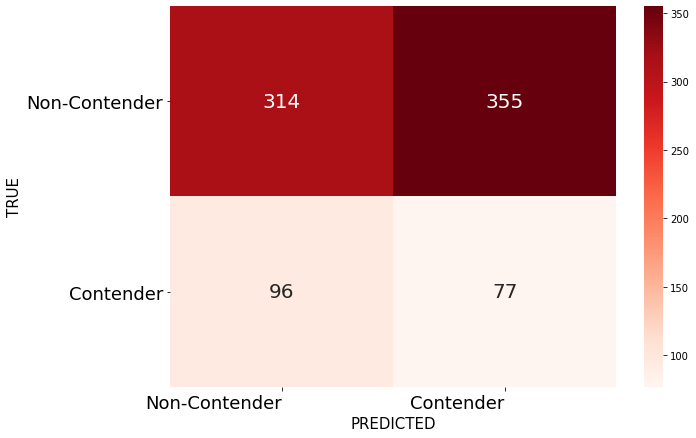

In [12]:
cm = print_confusion_matrix(confusion_matrix(y_test, y_base_pred), 
                      ['Non-Contender', 'Contender'], cmap='Reds')

### Linear Kernel Test
- Use default parameters, linear kernel, and non-oversampled training data.

In [13]:
# Linear Kernel 
svc_linear = SVC(C=1, kernel='linear', probability=True)
svc_linear.fit(X_train, y_train)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [14]:
y_svc_linear_pred = svc_linear.predict(X_test)
y_svc_linear_probas = svc_linear.predict_proba(X_test)

In [15]:
score_df(y_test, y_svc_linear_pred, y_svc_linear_probas)

,Scores
f1,0.452381
precision,0.721519
recall,0.329480
accuracy,0.836105
average_precision,0.375493
roc_auc,0.838816


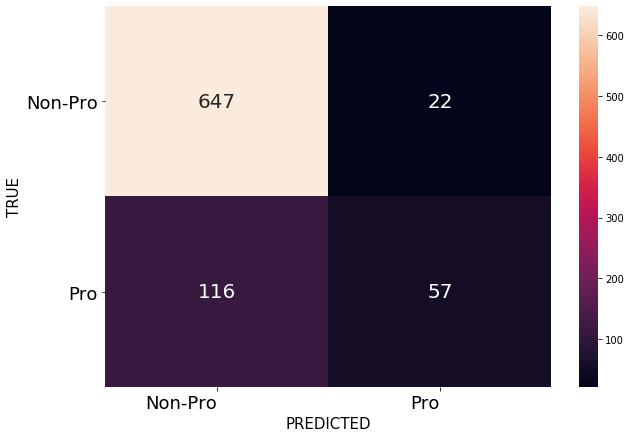

In [16]:
cnf_matrix = metrics.confusion_matrix(y_test, y_svc_linear_pred)
cm = print_confusion_matrix(cnf_matrix, 
                      ['Non-Pro', 'Pro'])

- Aha, very revealing. The accuracy score is good, but that's just b/c its putting everything in the Non-Pro category. So... this prediction is currently worthless.

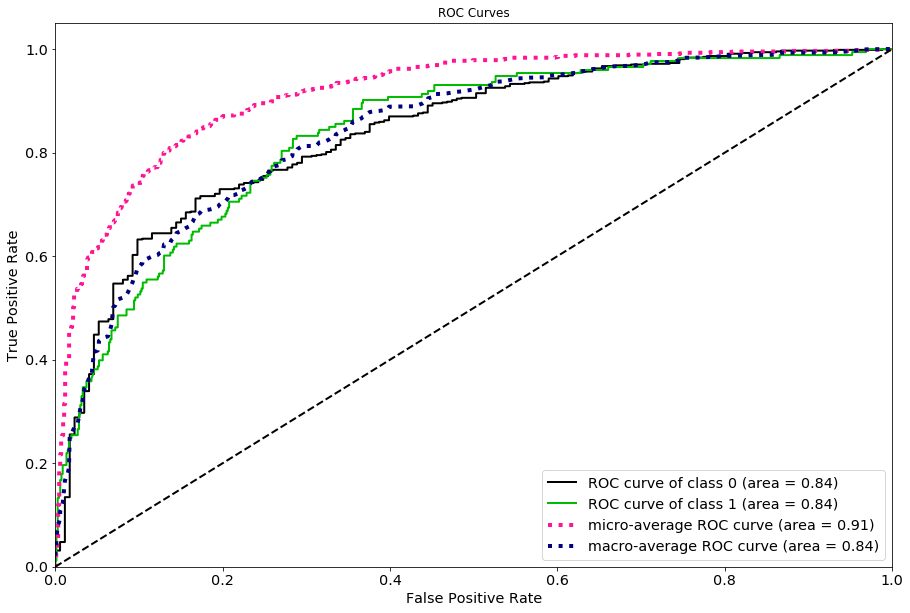

In [17]:
skplt.metrics.plot_roc(y_test, y_svc_linear_probas, figsize=(15,10), text_fontsize='x-large');

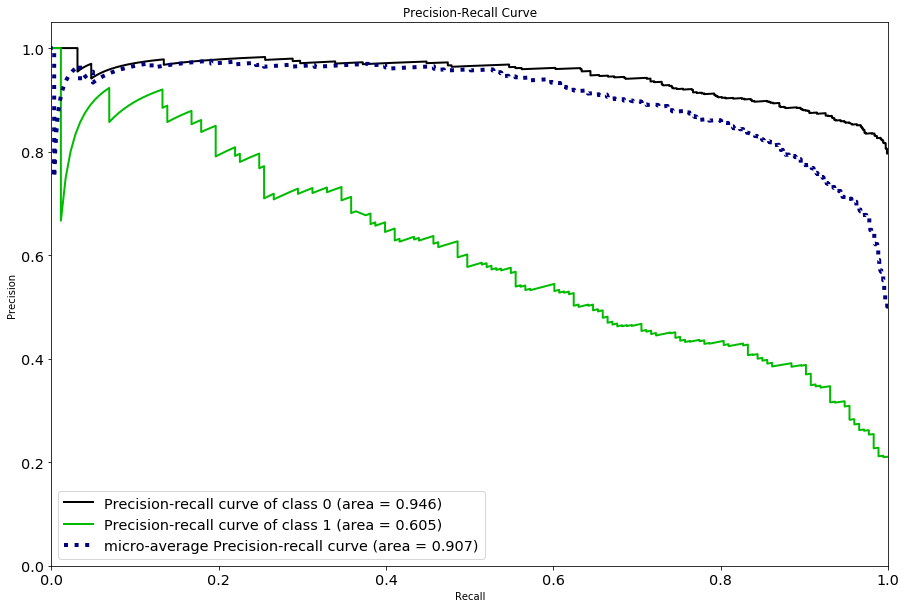

In [18]:
skplt.metrics.plot_precision_recall(y_test, y_svc_linear_probas, figsize=(15,10), text_fontsize='x-large');

### Polynomial Kernel Test

In [19]:
# Polynomial Kernel
poly_svc = SVC(kernel='poly', probability=True)
poly_svc.fit(X_train, y_train)
y_poly_svc_pred = poly_svc.predict(X_test)
y_poly_svc_probas = poly_svc.predict_proba(X_test)
score_df(y_test, y_poly_svc_pred, y_poly_svc_probas)

,Scores
f1,0.314815
precision,0.790698
recall,0.196532
accuracy,0.824228
average_precision,0.320480
roc_auc,0.837710


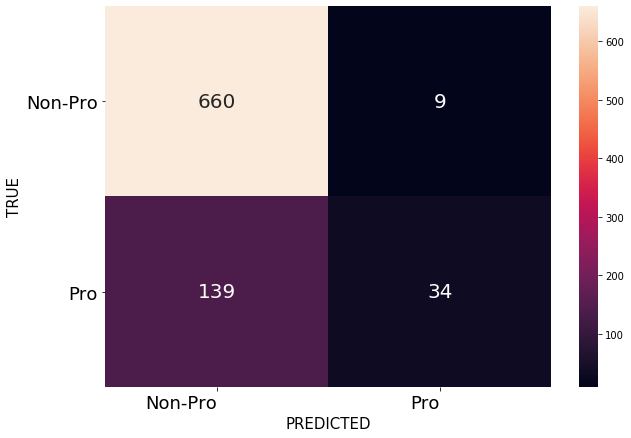

In [20]:
cnf_matrix = metrics.confusion_matrix(y_test, y_poly_svc_pred)
cm = print_confusion_matrix(cnf_matrix, ['Non-Pro','Pro'])

- Similar performance to the linear kernel, which was not great, and __recall is even worse...__

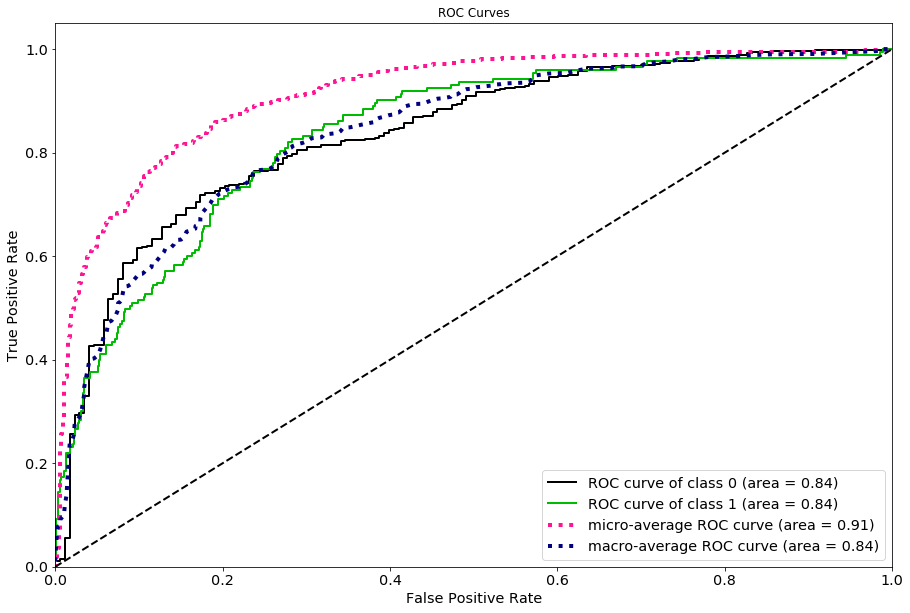

In [21]:
skplt.metrics.plot_roc(y_test, y_poly_svc_probas, figsize=(15,10), text_fontsize='x-large');

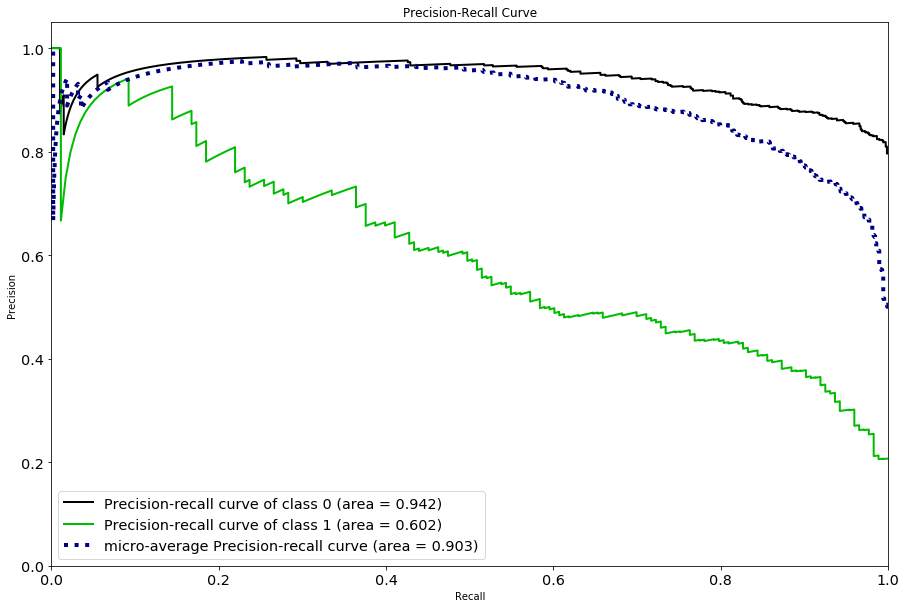

In [22]:
skplt.metrics.plot_precision_recall(y_test, y_poly_svc_probas, figsize=(15,10), text_fontsize='x-large');

### Sigmoid Kernel Test

In [23]:
# Sigmoid Kernel
sig_svc = SVC(kernel='sigmoid', probability=True)
sig_svc.fit(X_train, y_train)
y_sig_svc_pred = sig_svc.predict(X_test)
y_sig_svc_probas = sig_svc.predict_proba(X_test)
score_df(y_test, y_sig_svc_pred, y_sig_svc_probas)

,Scores
f1,0.512821
precision,0.505618
recall,0.520231
accuracy,0.796912
average_precision,0.361613
roc_auc,0.186889


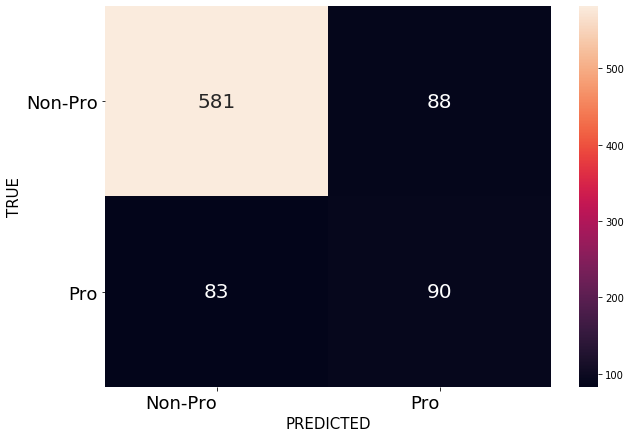

In [24]:
cnf_matrix = metrics.confusion_matrix(y_test, y_sig_svc_pred)
cm = print_confusion_matrix(cnf_matrix, ['Non-Pro', 'Pro'])

- Generally worse than linear and polynomial. 

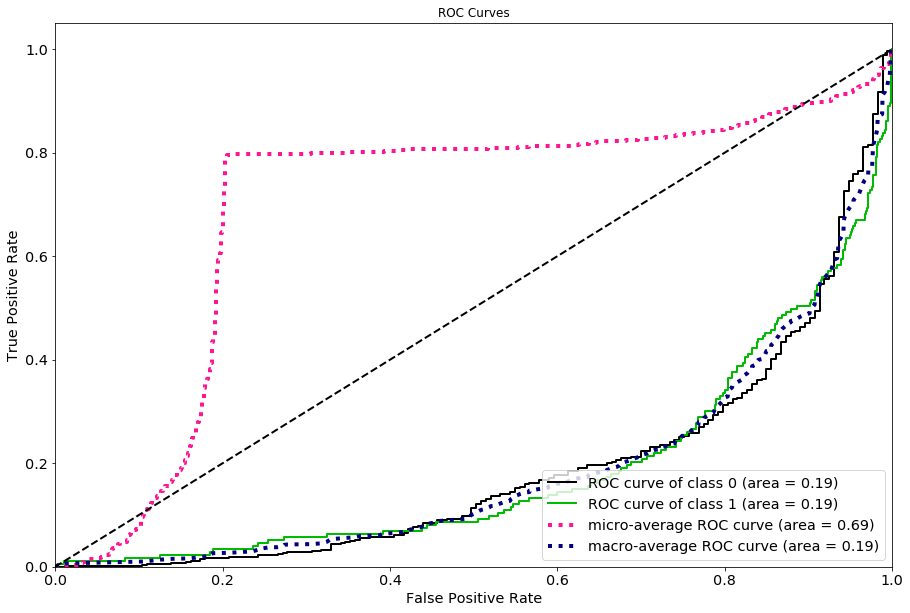

In [25]:
skplt.metrics.plot_roc(y_test, y_sig_svc_probas, figsize=(15,10), text_fontsize='x-large');

- __This ROC curve is strangely awful__. Pretty much inverted. That this is not reflected in the top four metrics is very odd... In any case, it is not a top performer amongst these models. 

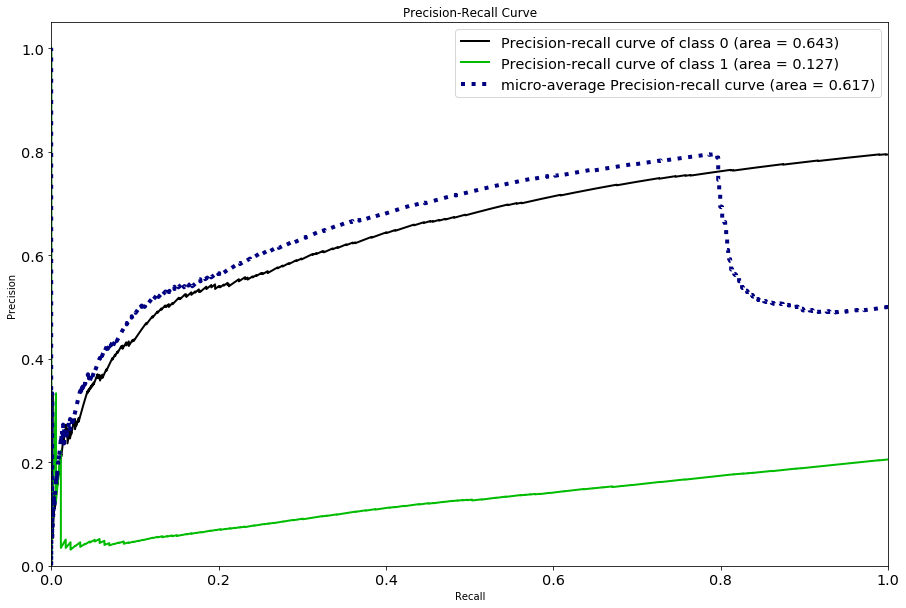

In [26]:
skplt.metrics.plot_precision_recall(y_test, y_sig_svc_probas, figsize=(15,10), text_fontsize='x-large');

- Again a strange curve. Sigmoid seems ill-suited for this problem. 

### RBF Kernel Test

In [27]:
# RBF Kernel
rbf_svc = SVC(probability=True)
rbf_svc.fit(X_train, y_train)
y_rbf_svc_pred = rbf_svc.predict(X_test)
y_rbf_svc_probas = rbf_svc.predict_proba(X_test)
score_df(y_test, y_rbf_svc_pred, y_rbf_svc_probas)

,Scores
f1,0.444444
precision,0.708861
recall,0.323699
accuracy,0.833729
average_precision,0.368413
roc_auc,0.773067


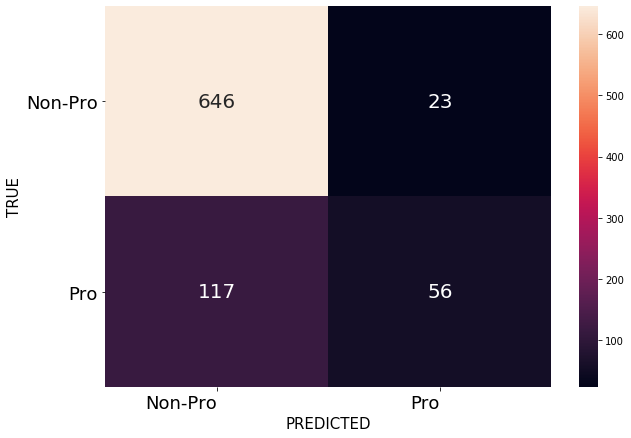

In [28]:
cnf_matrix = metrics.confusion_matrix(y_test, y_rbf_svc_pred)
cm = print_confusion_matrix(cnf_matrix, ['Non-Pro', 'Pro'])

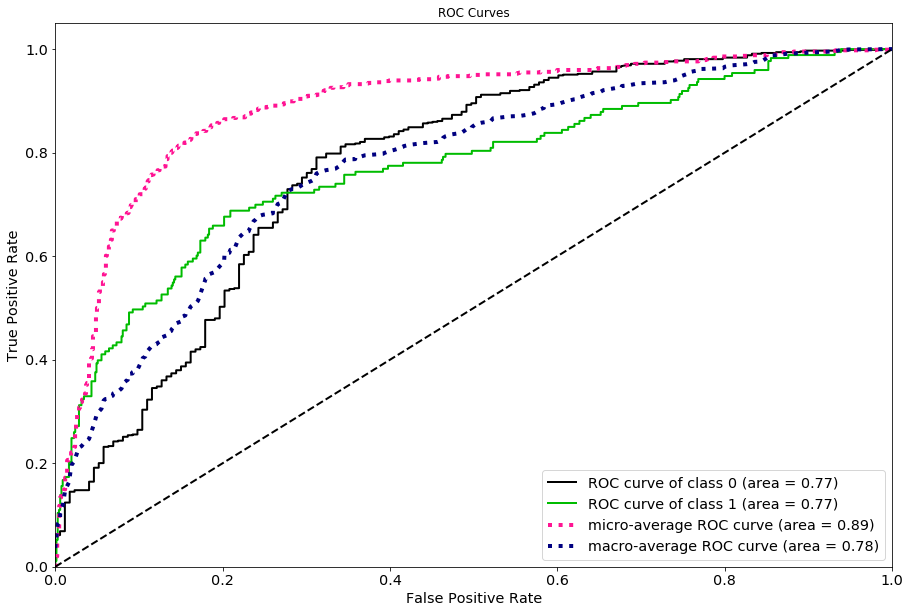

In [29]:
skplt.metrics.plot_roc(y_test, y_rbf_svc_probas, figsize=(15,10), text_fontsize='x-large');

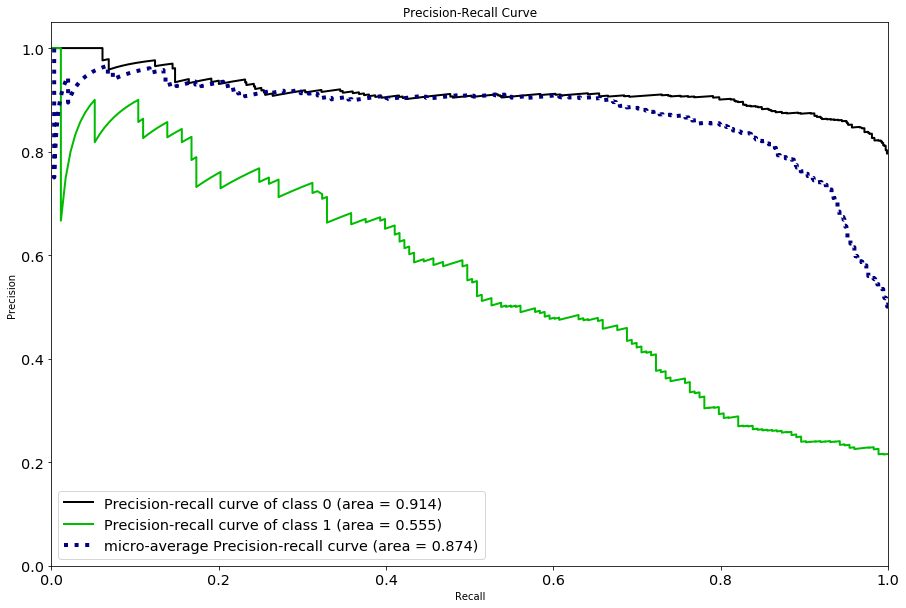

In [30]:
skplt.metrics.plot_precision_recall(y_test, y_rbf_svc_probas, figsize=(15,10), text_fontsize='x-large');

### Default Parameter Test Summary
- All of these SVC kernels __outperformed baseline__, but in general __did not perform terribly well__. 

## GridSearchCV
- Let's use GridSearchCV to see if we can find better hyperparameters and performance. 

### Standard Scaler
- I don't plan on graphically plotting the results and scaling is necessary for linear kernels so I'll transform the data with StandardScaler first.

In [50]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

### Train-Test-Split

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

### Oversample

In [53]:
ros  = RandomOverSampler(random_state=0)
X_ros, y_ros = ros.fit_resample(X_train, y_train)

### GridSearch 1 - RBF, Linear Kernel

In [54]:
svc = SVC()
scores = ['f1', 'precision', 'recall', 'accuracy', 'average_precision', 'roc_auc' ]
params = [{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
          {'C': [1, 10, 100, 1000], 'gamma': [0.01, 0.001, 0.0001], 'kernel': ['rbf']},
          ]
grid1 = GridSearchCV(svc, param_grid=params, scoring=scores, refit='f1')
grid1.fit(X_ros, y_ros)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000],
                          'gamma': [0.01, 0.001, 0.0001], 'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['f1', 'precision', 'recall', 'accuracy',
                      'average_precision', 'roc_auc'],
             verbose=0)

In [55]:
results_columns = ['param_C',
 'param_kernel',
 'param_degree', 
 'param_gamma',
 'mean_test_f1',
 'rank_test_f1',
 'mean_test_precision',
 'rank_test_precision',
 'mean_test_recall',
 'rank_test_recall',
 'mean_test_accuracy',
 'rank_test_accuracy',
 'mean_test_average_precision',
 'rank_test_average_precision',
 'mean_test_roc_auc',
 'rank_test_roc_auc',
 'mean_fit_time',
 'mean_score_time'
 ]

In [56]:
scores_columns = [ 'mean_test_f1',
 'mean_test_precision',
 'mean_test_recall',
 'mean_test_accuracy',
 'mean_test_average_precision',
 'mean_test_roc_auc',
 'mean_fit_time',
 'mean_score_time']

In [57]:
grid1_df = pd.DataFrame(grid1.cv_results_, columns=results_columns)
grid1_scores = pd.DataFrame(grid1_df.sort_values('rank_test_average_precision'), 
                            columns=scores_columns).round(4)

In [58]:
grid1_scores.iloc[0]

mean_test_f1                   0.8041
mean_test_precision            0.7912
mean_test_recall               0.8178
mean_test_accuracy             0.8006
mean_test_average_precision    0.8747
mean_test_roc_auc              0.8819
mean_fit_time                  0.1423
mean_score_time                0.0451
Name: 4, dtype: float64

In [59]:
grid1_df.sort_values('rank_test_average_precision').iloc[0]

param_C                                1
param_kernel                         rbf
param_degree                         NaN
param_gamma                         0.01
mean_test_f1                    0.804052
rank_test_f1                           3
mean_test_precision              0.79119
rank_test_precision                   13
mean_test_recall                0.817817
rank_test_recall                       4
mean_test_accuracy               0.80055
rank_test_accuracy                     4
mean_test_average_precision     0.874692
rank_test_average_precision            1
mean_test_roc_auc               0.881934
rank_test_roc_auc                      4
mean_fit_time                   0.142306
mean_score_time                0.0451361
Name: 4, dtype: object

- These scores for the top F1 are not great. The __top parameters were: linear, gamma=0.0001, C=1000__.
- It's also worth noting that __the top average precision score has a much faster fit_time (0.0541 vs 0.3585)__. The linear kernel seems to be very slow. 

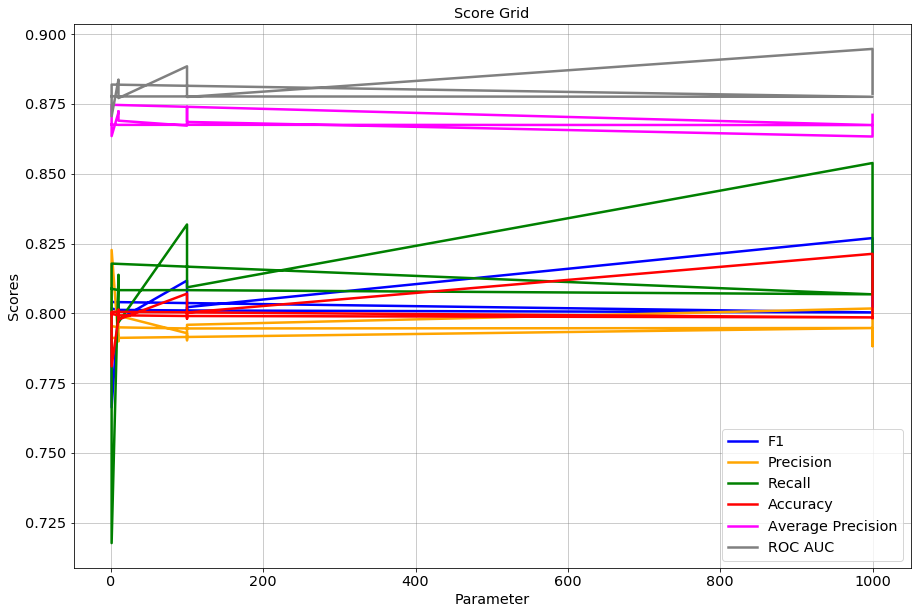

In [60]:
grid1_scores = [grid1_df.mean_test_f1,
                grid1_df.mean_test_precision,
                grid1_df.mean_test_recall,
                grid1_df.mean_test_accuracy,
                grid1_df.mean_test_average_precision,
                grid1_df.mean_test_roc_auc]
grid1_labels = ['F1', 'Precision', 'Recall', 'Accuracy', 'Average Precision', 'ROC AUC']
plot_grid_scores(grid1_df.param_C, grid1_scores, grid1_labels, linewidth=2.5)

- For the sake of curiosity and pain we'll run a GridSearch on the polynomial kernel as well. 

### GridSearchCV 3 (RBF)

In [61]:
svc = SVC()
scores = ['f1', 'precision', 'recall', 'accuracy', 'average_precision', 'roc_auc' ]
params = [{'C': [1, 10, 100, 1000], 'gamma': [0.01, 0.001, 0.0001], 'kernel': ['rbf']}]
grid3 = GridSearchCV(svc, param_grid=params, scoring=scores, refit='f1')
grid3.fit(X_ros, y_ros)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [1, 10, 100, 1000],
                          'gamma': [0.01, 0.001, 0.0001], 'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['f1', 'precision', 'recall', 'accuracy',
                      'average_precision', 'roc_auc'],
             verbose=0)

In [62]:
grid3_df = pd.DataFrame(grid3.cv_results_, columns=results_columns)
grid3_scores = pd.DataFrame(grid3_df.sort_values('rank_test_average_precision'), 
                            columns=scores_columns).round(4)
grid3_scores.iloc[0]

mean_test_f1                   0.8041
mean_test_precision            0.7912
mean_test_recall               0.8178
mean_test_accuracy             0.8006
mean_test_average_precision    0.8747
mean_test_roc_auc              0.8819
mean_fit_time                  0.1417
mean_score_time                0.0501
Name: 0, dtype: float64

In [63]:
grid3_df.sort_values(['rank_test_f1']).iloc[0]

param_C                             1000
param_kernel                         rbf
param_degree                         NaN
param_gamma                         0.01
mean_test_f1                    0.826963
rank_test_f1                           1
mean_test_precision              0.80175
rank_test_precision                    2
mean_test_recall                0.853845
rank_test_recall                       1
mean_test_accuracy              0.821322
rank_test_accuracy                     1
mean_test_average_precision      0.86333
rank_test_average_precision           12
mean_test_roc_auc                0.89471
rank_test_roc_auc                      1
mean_fit_time                    1.50392
mean_score_time                0.0482457
Name: 9, dtype: object

## TEST: RBF Using GridSearchCV Results
- Based upon the __F1 metric__ the __RBF kernel__ had the __overall best scores__ as well as a __good execution time__ so we will __use RBF for test__. 


### SVC (RBF) TEST

In [71]:
rbf_test = SVC(C=1000, gamma=0.01, probability=True)
rbf_test.fit(X_ros, y_ros)

SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [73]:
y_pred = rbf_test.predict(X_test)
y_probas = rbf_test.predict_proba(X_test)

In [74]:
score_df(y_test, y_pred, y_proba=y_probas).round(4)

,Scores
f1,0.5674
precision,0.4747
recall,0.7052
accuracy,0.7791
average_precision,0.3953
roc_auc,0.8341


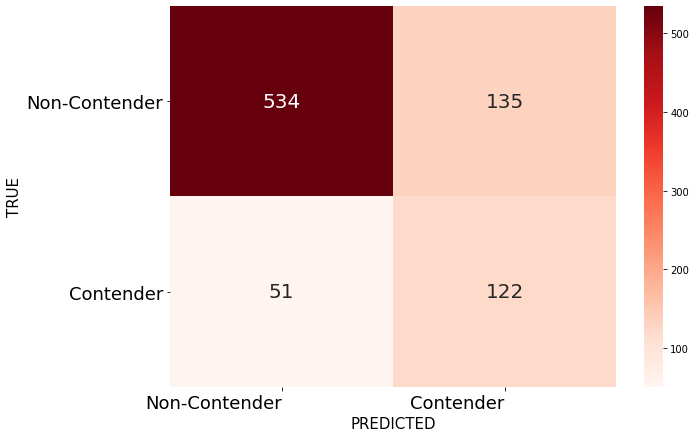

In [75]:
cnf_matrix = metrics.confusion_matrix(y_test,y_pred)
cm = print_confusion_matrix(cnf_matrix, ['Non-Contender', 'Contender'], cmap='Reds')

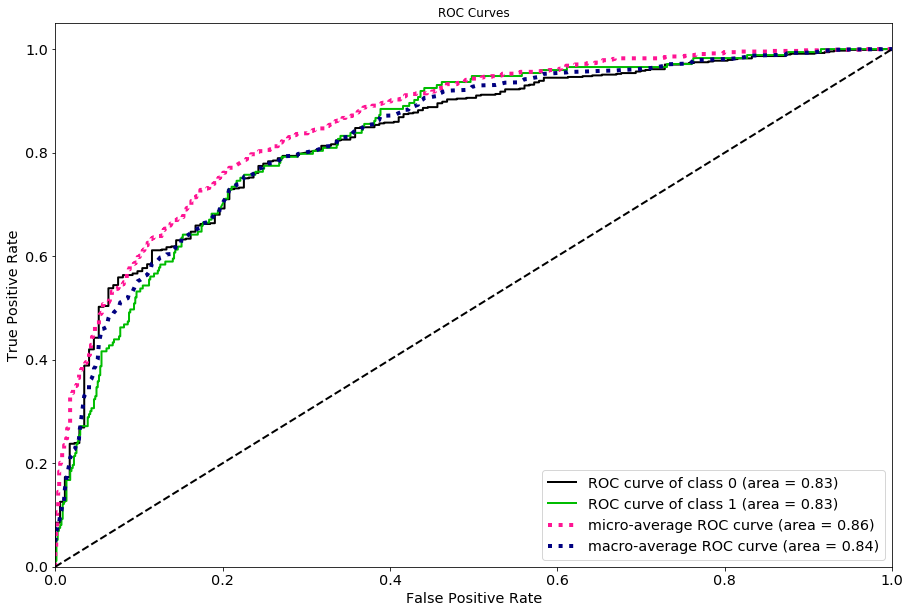

In [76]:
skplt.metrics.plot_roc(y_test, y_probas, figsize=(15,10), text_fontsize='x-large');

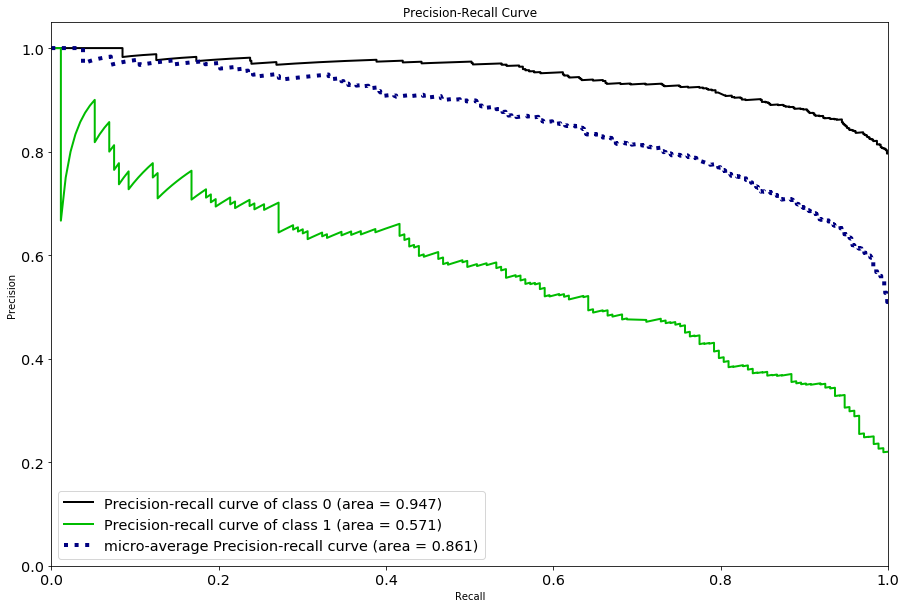

In [77]:
skplt.metrics.plot_precision_recall(y_test, y_probas, figsize=(15,10), text_fontsize='x-large');

## SVC Summary 
- __SVC (RBF) Scores__
    - F1: __0.5674__
    - Precision: __0.4747__
    - Recall: __0.7052__
    - Accuracy: __0.7791__
    - Average Precision: __0.3953__
    - ROC AUC: __0.8341__
- RBF with the hyperparameters found through GridSearchCV showed __significant improvement over baseline__ a.
- When compared to KNN __the scores are comparable, with each performing slightly better than the other on given metrics__.
- The one are where __KNN is the decisive winner__ is __execution time__. __SVC with an rbf kernel__ is __orders of magnitude slower: KNN=0.007 vs SVC=8.30__.  